In [1]:
%matplotlib inline

In [13]:
from __future__ import print_function
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import time
import cv2

In [3]:
class matchers:
    def __init__(self):
        self.surf = cv2.xfeatures2d.SURF_create()
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm=0, trees=5)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(index_params, search_params)

    def match(self, i1, i2, direction=None):
        imageSet1 = self.getSURFFeatures(i1)
        imageSet2 = self.getSURFFeatures(i2)
        print("Direction : ", direction)
        matches = self.flann.knnMatch(
            imageSet2['des'],
            imageSet1['des'],
            k=2
            )
        good = []
        for i , (m, n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                good.append((m.trainIdx, m.queryIdx))

        if len(good) > 4:
            pointsCurrent = imageSet2['kp']
            pointsPrevious = imageSet1['kp']

            matchedPointsCurrent = np.float32(
                [pointsCurrent[i].pt for (__, i) in good]
            )
            matchedPointsPrev = np.float32(
                [pointsPrevious[i].pt for (i, __) in good]
                )

            H, s = cv2.findHomography(matchedPointsCurrent, matchedPointsPrev, cv2.RANSAC, 4)
            return H
        return None

    def getSURFFeatures(self, im):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kp, des = self.surf.detectAndCompute(gray, None)
        return {'kp':kp, 'des':des}

In [18]:
class Stitch:
    def __init__(self, args):
        self.path = args
        fp = open(self.path, 'r')
        filenames = [each.rstrip('\r\n') for each in  fp.readlines()]
        print(filenames)
        self.images = [cv2.resize(cv2.imread(each),(480, 320)) for each in filenames]
        self.count = len(self.images)
        self.left_list, self.right_list, self.center_im = [], [],None
        self.matcher_obj = matchers()
        self.prepare_lists()

    def prepare_lists(self):
        print("Number of images : %d"%self.count)
        self.centerIdx = self.count/2
        print("Center index image : %d"%self.centerIdx)
        self.center_im = self.images[int(self.centerIdx)]
        for i in range(self.count):
            if(i<=self.centerIdx):
                self.left_list.append(self.images[i])
            else:
                self.right_list.append(self.images[i])
        print("Image lists prepared")

    def leftshift(self):
        # self.left_list = reversed(self.left_list)
        a = self.left_list[0]
        for b in self.left_list[1:]:
            H = self.matcher_obj.match(a, b, 'left')
            print("Homography is : ", H)
            xh = np.linalg.inv(H)
            print("Inverse Homography :", xh)
            ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]));
            ds = ds/ds[-1]
            print("final ds=>", ds)
            f1 = np.dot(xh, np.array([0,0,1]))
            f1 = f1/f1[-1]
            xh[0][-1] += abs(f1[0])
            xh[1][-1] += abs(f1[1])
            ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]))
            offsety = abs(int(f1[1]))
            offsetx = abs(int(f1[0]))
            dsize = (int(ds[0])+offsetx, int(ds[1]) + offsety)
            print("image dsize =>", dsize)
            tmp = cv2.warpPerspective(a, xh, dsize)
            tmp[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx] = b
            a = tmp

        self.leftImage = tmp

    def rightshift(self):
        for each in self.right_list:
            H = self.matcher_obj.match(self.leftImage, each, 'right')
            print("Homography :", H)
            txyz = np.dot(H, np.array([each.shape[1], each.shape[0], 1]))
            txyz = txyz/txyz[-1]
            dsize = (int(txyz[0])+self.leftImage.shape[1], int(txyz[1])+self.leftImage.shape[0])
            tmp = cv2.warpPerspective(each, H, dsize)
            # tmp[:self.leftImage.shape[0], :self.leftImage.shape[1]]=self.leftImage
            tmp = self.mix_and_match(self.leftImage, tmp)
            print("tmp shape",tmp.shape)
            print("self.leftimage shape=", self.leftImage.shape)
            self.leftImage = tmp

    def mix_and_match(self, leftImage, warpedImage):
        i1y, i1x = leftImage.shape[:2]
        i2y, i2x = warpedImage.shape[:2]
        print(leftImage[-1,-1])

        t = time.time()
        black_l = np.where(leftImage == np.array([0,0,0]))
        black_wi = np.where(warpedImage == np.array([0,0,0]))
        print(time.time() - t)
        print(black_l[-1])

        for i in range(0, i1x):
            for j in range(0, i1y):
                try:
                    if(np.array_equal(leftImage[j,i],np.array([0,0,0])) and  np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
                        # print "BLACK"
                        # instead of just putting it with black,
                        # take average of all nearby values and avg it.
                        warpedImage[j,i] = [0, 0, 0]
                    else:
                        if(np.array_equal(warpedImage[j,i],[0,0,0])):
                            # print "PIXEL"
                            warpedImage[j,i] = leftImage[j,i]
                        else:
                            if not np.array_equal(leftImage[j,i], [0,0,0]):
                                bw, gw, rw = warpedImage[j,i]
                                bl,gl,rl = leftImage[j,i]
#                                 b = (bl+bw)/2
#                                 g = (gl+gw)/2
#                                 r = (rl+rw)/2
                                warpedImage[j, i] = [bl,gl,rl]
                except:
                    pass
        return warpedImage

['../images/S1.jpg', '../images/S2.jpg', '../images/S3.jpg', '../images/S5.jpg', '../images/S6.jpg']
Number of images : 5
Center index image : 2
Image lists prepared
Direction :  left
Homography is :  [[  7.82327304e-01  -5.28578314e-02   1.83944616e+02]
 [ -5.44189211e-02   9.18393443e-01   8.62039675e+00]
 [ -4.53086457e-04  -4.04781607e-05   1.00000000e+00]]
Inverse Homography : [[  1.15851587e+00   5.72637445e-02  -2.13596393e+02]
 [  6.36960600e-02   1.09159280e+00  -2.11265103e+01]
 [  5.27486150e-04   7.01310961e-05   9.02367205e-01]]
final ds=> [ 306.29444417  304.54714086    1.        ]
image dsize => (833, 405)
Direction :  left
Homography is :  [[  6.11349831e-01  -6.04765973e-02   4.31857334e+02]
 [ -7.93108765e-02   9.24742354e-01   3.95470539e+01]
 [ -5.30508561e-04   2.09623544e-05   1.00000000e+00]]
Inverse Homography : [[  1.19608048e+00   9.00113527e-02  -5.20095811e+02]
 [  7.55139665e-02   1.08803540e+00  -7.56398548e+01]
 [  6.32947984e-04   2.49440096e-05   7.2567

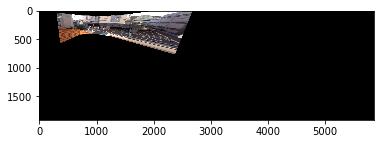

In [27]:

files = "./txtlists/files1.txt"
s = Stitch(files)
s.leftshift()
s.rightshift()
cv2.imwrite("test12.jpg", s.leftImage)
plt.imshow(s.leftImage)

In [22]:
def autocrop(image, threshold=0):
    """Crops any edges below or equal to threshold

    Crops blank image to 1x1.

    Returns cropped image.

    """
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image

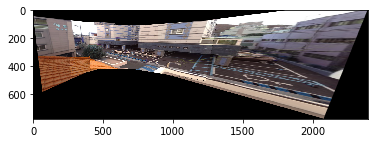

In [28]:
im = autocrop(s.leftImage)
plt.imshow(im)

In [24]:
import sys
sys.version_info

sys.version_info(major=2, minor=7, micro=13, releaselevel='final', serial=0)